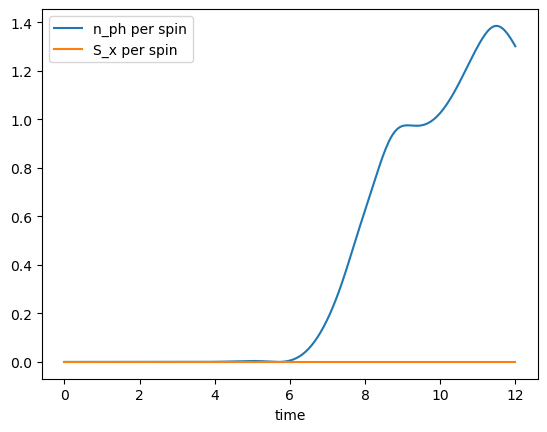

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve

# -------------------------
# parameters
N = 6          # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

# -------------------------
# time-dependence
def g_t(t, args):
    g0 = args.get('g0', 2.0)
    t0 = args.get('t0', 5.0)
    tau = args.get('tau', 1.0)
    return g0 * 0.5 * (1 + np.tanh((t - t0)/tau))

def gdot_t(t, args):
    g0 = args.get('g0', 2.0)
    t0 = args.get('t0', 5.0)
    tau = args.get('tau', 1.0)
    return g0 * 0.5 * (1 - np.tanh((t - t0)/tau)**2) / tau

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)

# Hamiltonian list for sesolve
H_td = [[V, coeff]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 0), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

# evolve
tlist = np.linspace(0, 12, 300)
args = {'g0': 2.0, 't0': 5.0, 'tau': 1.0}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N

# plot
plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.xlabel("time")
plt.legend()
plt.show()


## We consider a sinusoidal transverse periodic external field

Trial: Bessel function type of root

In [1]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.sin(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0  =  empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)

    return H0

print("Function defined !")

Function defined !


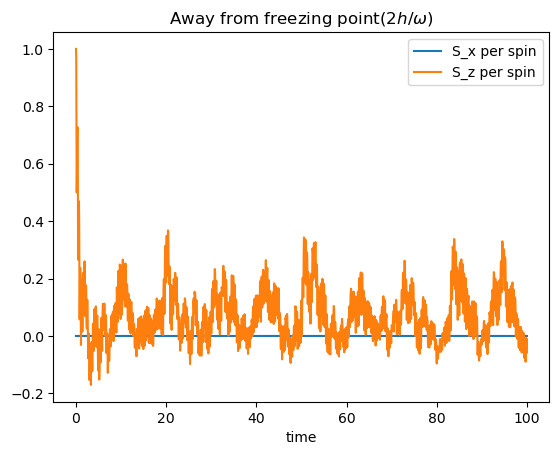

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

# -------------------------
# parameters
N = 5        # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = jn_zeros(0, 1)[0] * omega / 2

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph)) + hbar * omega * tensor(qeye(2**N), adag*a)

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 1), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

op_Sz = tensor(I_ph, sum(spin_only_op(sigmaz(), i, N) for i in range(N)))

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx, op_Sz], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N
Sz_t  = np.real(result.expect[2]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.plot(tlist, Sz_t, label='S_z per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"Away from freezing point($2h/\omega$)")
#plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

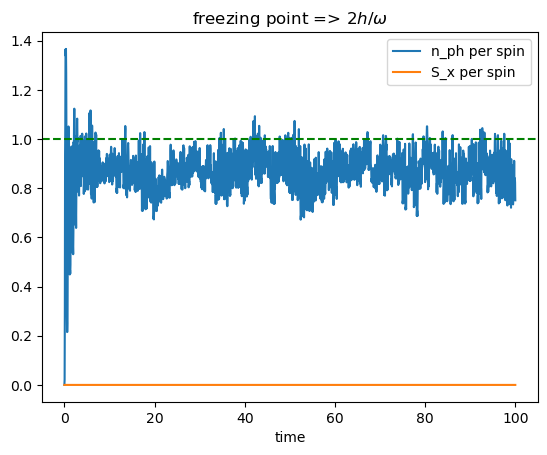

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

# -------------------------
# parameters
N = 6        # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = jn_zeros(0,2)[0] * omega / 2

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph))

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 0), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N

# plot
plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"freezing point => $2h/\omega$")
plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

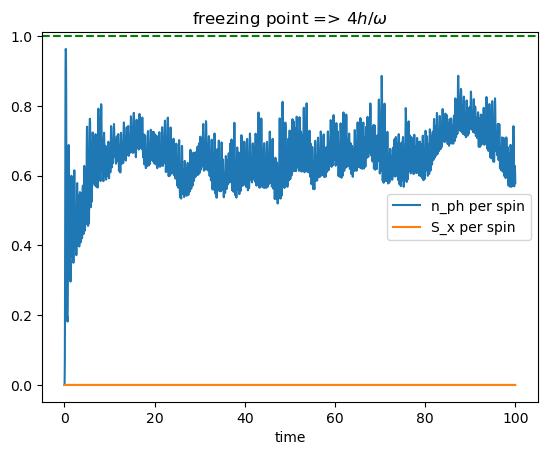

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

# -------------------------
# parameters
N = 6        # number of spins
n_ph = 20      # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = jn_zeros(0,2)[0] * omega / 4

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph))

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 0), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N

# plot
plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"freezing point => $4h/\omega$")
plt.axhline(y =1, ls = '--', color = 'green')
plt.show()